# Computer Assigment 5 - PageRank



* The goal of this project is to explore PageRank following the methods presented in the `Deeper Inside PageRank` Paper (Amy N. Langville and Carl D. Meyer, October 20, 2004). 

*"The original Brin and Page model for PageRank uses the hyperlink structure of the Web to build a Markov chain with a primitive1 transition probability matrix $\bm{P}$. The irreducibility of the chain guarantees that the long-run stationary vector $\bm{\pi}^T$, known as the PageRank vector, exists."*

## Imports

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler

# scipy
from scipy import sparse
from scipy.sparse import csr_matrix, csc_matrix
from scipy.sparse.linalg import splu
import time


%matplotlib inline
plt.rcParams.update(plt.rcParamsDefault)

## Read Data

* In the file `Stanweb.dat`, you will find in compressed form the connectivity matrix for the webpages of Stanford University. Speciffically in the first column are contained the nodes while in the second the node with which is connected.

Our first goal is to read the data and build the Markov model square matrix $\bm{P}$ *"whose element $p_{ij}$ is the probability of moving from state $i$ (page $i$) to state $j$ (page $j$) in one time step.*

Due to the volume of the data, we need to use libraries that support sparse matrices. We decided to use scipy's [sparse.csr_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) which is one of the most common libraries.

After loading the data we took the necessary steps and created $\bm{P}$ matrix. 

In [14]:
#load df and create sparse matrix P
data = pd.read_csv('stanweb.dat', names = ['Node', 'Link', 'Prob'], sep='\t', header=None)


In [15]:
# Define variables for the csr_matrix
n = data.Node.max()

# Python starts counting from zero we will correct that
row = data.Node - 1
column = data.Link - 1
propabilities = data.Prob

# define P matrix
P = csr_matrix((propabilities, (row, column)), shape=(n, n))
P

<281903x281903 sparse matrix of type '<class 'numpy.float64'>'
	with 2312497 stored elements in Compressed Sparse Row format>

# Part 1

## a) Find the vector $\pi$ 


* Find the vector $\pi$ as they described in paragraph 5.1 and 5.2 of the tutorial. For both methods consider as  $\alpha$ = 0.85 and stopping criterion $\tau$ = $10^{-8}$ and the vector $\alpha$ having 1 if it is corresponds to a node with no out links and 0 otherwise. \
* Are the results the same for both methods? 
* Which method seems to be faster? 

Use Gauss Seidel method for the iterative solution of the system.

### i) Power method

* Before proceeding with the calculation, some matrices need to be presented, which will later be calculated. Those are presented in the paper, thus, for the sake of simplicity, will not be explained in detail in this project.

$\textbf{a}$: vector which Element $a_i$ = 1 if row i of $\bm{P}$ corresponds to a dangling node, and 0, otherwise. \
$\textbf{v}^T$: uniform vectoe $\dfrac{1}{n}\textbf{e}^T$ \
$\textbf{x}^{(0)T}$: starting vector \
$\textbf{x}^{(k)T}$: probability vector\

where: 
$\textbf{x}^{(k)T} = \alpha \textbf{x}^{(k-1)T} \bm{P} + (\alpha \textbf{x}^{(k-1)T} \textbf{a} + (1 - \alpha)) \textbf{v}^T$ \\

A rough estimate of the number of iterations needed to converge to a tolerance level $\tau$  (measured by the
residual, $\textbf{x}^{(k)T} \bar{\bar{\bm{P}}} − \textbf{x}^{(k)T} = \textbf{x}^{(k+1)T} − \textbf{x}^{(k)T}$) is $\dfrac{log_{10} \tau}{log_{10} \alpha}$.

In [16]:
def power_method(P, a , t, save_x = True):
    """"
    Function that implements the power method as described in chapter 5.1 of the corresponding paper
    Input: P -> Markov model square matrix, a -> float, t -> tolerance level
    Output: -> ranking vector
    """
    # Find rows with all zeros
    (n,d)=P.shape 
    zero_rows = P.sum(axis=1)==0
    index = np.argwhere(zero_rows)

    # create vector a
    a_v = np.zeros(n)
    a_v[index[:,0]] = 1 
    
    # Define v^T
    vT = np.ones(d) / n 
    
    # define x(0)T
    x = np.ones(d) /  n 
    

    error_list, top, bottom = [], [(np.argsort(x.flatten())+1)[::-1][:50]], [(np.argsort(x.flatten())+1)[::-1][-50:]]
    
    # set iterations to 1500 in case the mothod doesn't converge
    for i in range(1500):  
        
        # Calculate X(k) given x(k-1). Since we are using sparse P we can use multiplication notation
        x_new = a * x * P + (a * x * a_v + (1 - a)) * vT

        if save_x:
            top.append((np.argsort(x_new.flatten())+1)[::-1][:50])
            bottom.append((np.argsort(x_new.flatten())+1)[::-1][-50:])   

        # error
        error = np.linalg.norm(x-x_new, ord=1)
        error_list.append(error)
        x = x_new
        if error < t:
            print(f"Method converged after {i} iterations for a={a}")

            x_new = x_new.reshape(n,1) 
            return x_new, i, error_list, np.array(top, dtype=object), np.array(bottom, dtype=object)

    print(f"Method did not converge for a={a}.")
    x_new = x_new.reshape(n,1)       
    return x_new, i, error_list, np.array(top, dtype=object), np.array(bottom, dtype=object)

* In order to have a fair representation of the actual time, we will run the method for a number tests and calculate the average time.

In [17]:
runtime_pm = 0
tests = 5

for i in range(tests):

    print(f"Test # {i+1}: ", end='')
    start_pm = time.time()
    x_pm, iter_pm, error_pm, top_pm, bottom_pm = power_method(P , 0.85, np.power(10.0, -8))
    end_pm = time.time()
    runtime_pm += end_pm-start_pm

print()
print(f"The average Total time for Power Method with a={0.85} is: {runtime_pm/tests:.2f}s.")

Test # 1: Method converged after 90 iterations for a=0.85
Test # 2: Method converged after 90 iterations for a=0.85
Test # 3: Method converged after 90 iterations for a=0.85
Test # 4: Method converged after 90 iterations for a=0.85
Test # 5: Method converged after 90 iterations for a=0.85

The average Total time for Power Method with a=0.85 is: 7.59s.


* We will save and print the Top 50 nodes.

In [18]:
def sort_top_50(x, display=True):
    """
    Function that prints and returns the ranking of the 50 first nodes given a vector.
    """
    top = (np.argsort(x.flatten())+1)[::-1][:50]
    if display:
        print(top)
    return top

In [19]:
top50_pm = sort_top_50(x_pm)

[ 89073 226411 241454 262860 134832 234704 136821  68889 105607  69358
  67756 225872 186750 251796 272442  95163 119479 231363  55788 167295
 179645  38342 117152 198090  60210 235496 132695 181701 247241 259455
 120708  62478 161890 176790 137632 221087 183004  77999  17781  96745
 112742 145892 151428  81435  60440 208542     91 214128 258348 222873]


### ii) Solving the corresponding system

As described in 5.2 the linear system formulation is given by:
$$\bm{\pi}^T (\bm{I} - \alpha \bm{P}) = \mathbf{v}^T $$

As we have explored in class there are multiple methods to solve systems like this one. One of the most popular ones (which is supported by spicy's documentation) is the [Gauss-Siedel](https://en.wikipedia.org/wiki/Gauss%E2%80%93Seidel_method) method, which in this case can be implemented using [`tril`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.tril.html) and [`triu`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.triu.html).

Using [handout-page_rank.pdf](http://snap.stanford.edu/class/cs224w-2017/slides/handout-page_rank.pdf) and [PageRank Tutorial](https://www.youtube.com/watch?v=KX1dMAb6LaU) we concluded that the linear system can be nailed down to a system of the form $\mathbf{A} \mathbf{x} = \mathbf{b}$ where $\mathbf{A} = \bm{I} - \alpha \bm{P}$ and $\mathbf{b}$ is the ranking vector.

In [20]:
def system_solver(P, a, t, save_x = True):
    """"
    Function that takes a matrix P as an input and solves the linear system using LU decomposition and the Gauss siedel method.
    Input: P -> Markov model square matrix, a -> float, t -> tolerance level
    Output: x(k)T -> ranking vector
    """

    # define identiry matrix
    (n,d) = P.shape
    I = sparse.identity(n,  format = 'csc')

    # define A matrix
    A = (I - a * P).T

    # define LU
    L = splu(sparse.tril(A, 0,  format = 'csc'))
    U = sparse.triu(A, 1,  format = 'csc') 

    # Define b and x
    b =  np.ones(d) / n 
    x =  np.ones(d) / n

    error_list, top, bottom = [], [(np.argsort(x.flatten())+1)[::-1][:50]], [(np.argsort(x.flatten())+1)[::-1][-50:]]
    # set iterations to 1000 in case the mothod doesn't converge
    for i in range(1000): 

        # Calculate X(k) given x(k-1). Since we are using sparse P we can use multiplication notation
        x_new = L.solve(b - U*x)

        if save_x:
            top.append((np.argsort(x_new.flatten())+1)[::-1][:50])
            bottom.append((np.argsort(x_new.flatten())+1)[::-1][-50:])

        # error
        error = np.linalg.norm(x-x_new, ord=1)
        error_list.append(error)
        x = x_new    
 
        if error < t:

            print(f"Method converged after {i} iterations for a={a}")

            x_new = x_new.reshape(n,1) 
            return x_new / np.sum(x_new), i, error_list, np.array(top, dtype=object), np.array(bottom, dtype=object)
    
    print(f"Method did not converge for a={a}.")
    x_new = x_new.reshape(n,1) 
    return x_new/np.sum(x_new), i, np.array(top, dtype=object), np.array(bottom, dtype=object)

In [21]:
runtime_ls = 0
tests = 5

for i in range(tests):

    print(f"Test # {i+1}: ", end='')
    start_ls = time.time()
    x_ls, iter_ls, error_ls, top_ls, bottom_ls = system_solver(P , 0.85, np.power(10.0, -8))
    end_ls = time.time()
    runtime_ls += end_ls-start_ls

print()
print(f"The average Total time for Power Method with a={0.85} is: {runtime_ls/tests:.2f}s.")

Test # 1: Method converged after 61 iterations for a=0.85
Test # 2: Method converged after 61 iterations for a=0.85
Test # 3: Method converged after 61 iterations for a=0.85
Test # 4: Method converged after 61 iterations for a=0.85
Test # 5: Method converged after 61 iterations for a=0.85

The average Total time for Power Method with a=0.85 is: 8.07s.


* Similar to the power method, will save and print the first 50 nodes.

In [22]:
top50_ls = sort_top_50(x_ls)

[ 89073 226411 241454 262860 134832 234704 136821  68889 105607  69358
  67756 225872 186750 272442 251796  95163 119479 231363  55788 167295
 179645  38342 117152 198090  60210 235496 132695 181701 259455 247241
 120708  62478 161890 221087 183004 176790 137632  77999  17781  96745
 112742 145892 151428  81435  60440 208542     91 214128 258348 222873]


### Comments on Part 1.a

#### Are the results the same for both methods? 

As shown below the two methods have similar results. The ranking probabilities of the top pages are similar, and in the top 50 pages, 8 indexes don't match. By further investigating that, we can see that the order has slightly changed, since there are no pages present in the power method and not in the linear, for the top 50 ranked pages.

In [23]:
df = pd.DataFrame({'Power Method Prob':x_pm[:,0],'Gauss Seidel Prob':x_ls[:,0]})
df=df.sort_values(by=['Power Method Prob'], ascending = False)
df.index = df.index + 1
df.head()

,Power Method Prob,Gauss Seidel Prob
89073,0.011276,0.011303
226411,0.009266,0.009288
241454,0.008278,0.008297
262860,0.003016,0.003023
134832,0.002994,0.003001


In [24]:
print(f"Total number of indexes where the ranking is different at the 50 first pages:")
print(np.where(top50_pm != top50_ls)[0].shape[0])

Total number of indexes where the ranking is different at the 50 first pages:
8


In [25]:
# Pages in top 50 of power method but not in linear system method
[i for i in top50_ls if i not in top50_pm]

[]

#### Which method seems to be faster? 

As seen from the corresponding times, the power method converges slower compared to the linear system (90 vs 61 iterations). That said, the power method has better performance in terms of time, which could be a result of the specific implementation. Moreover, as the paper suggests, there are improvements that can be applied on $\bm{P}$, which improve performance. 

In the graph below a comparison of the two error rates is displayed.

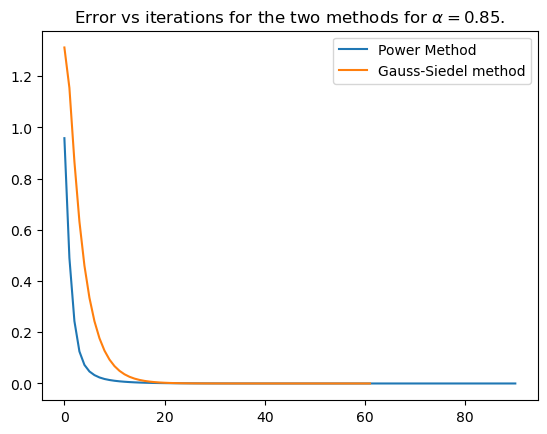

In [26]:
plt.plot(error_pm, label = 'Power Method')
plt.plot(error_ls, label = 'Gauss-Siedel method')


plt.title('Error vs iterations for the two methods for $\\alpha = 0.85$.')
plt.legend()
plt.show()

## b) Do the previous task with $\alpha$ = 0.99. 

* We will perform the same calculations, but using one test, since we expect the time to be much higher.

In [27]:
### Power method
start_pm99 = time.time()
x_pm99, iter_pm99, error_pm99, _, _ = power_method(P , 0.99, np.power(10.0, -8), False)
end_pm99 = time.time()
runtime_pm99 = end_pm99-start_pm99

print()
print(f"The average Total time for Power Method with a={0.99} is: {runtime_pm99:.2f}s.")


Method converged after 1391 iterations for a=0.99

The average Total time for Power Method with a=0.99 is: 31.09s.


In [28]:
### Power method
start_ls99 = time.time()
x_ls99, iter_ls99, error_ls99, _, _ = system_solver(P , 0.99, np.power(10.0, -8), False)
end_ls99 = time.time()
runtime_ls99 = end_ls99-start_ls99

print()
print(f"The average Total time for Power Method with a={0.99} is: {runtime_ls99:.2f}s.")


Method converged after 967 iterations for a=0.99

The average Total time for Power Method with a=0.99 is: 42.08s.


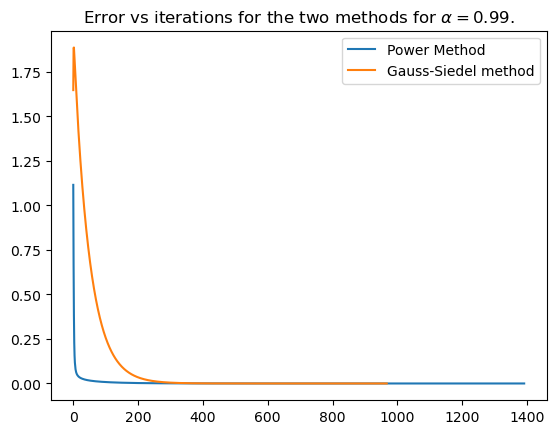

In [29]:
plt.plot(error_pm99, label = 'Power Method')
plt.plot(error_ls99, label = 'Gauss-Siedel method')


plt.title('Error vs iterations for the two methods for $\\alpha = 0.99$.')
plt.legend()
plt.show()

### Your remarks on the convergence speed. 

As expected the convergence speed decreased for both methods, using a higher $\alpha$. As mentioned in Chapter 6 of the paper, *"Whereas $\alpha$ = .99, not only slows convergence of the power method, but also places much greater emphasis on the hyperlink structure of the Web and much less on the teleportation tendencies of surfers."*

While *"The PageRank vector derived from $\alpha$ = .99 [...] gives a “truer” PageRanking."* the user would, at some point, move to another website by typing it in the explorer. 

More info on the selection of $\alpha$ can be found in Chapter 7.

### Did the ranking of the frst 50 nodes changed?

We will compare the ranking of the top 15 pages, for the 4 methods. As expected, for the same values of $\alpha$ the two methods have similar results, but the results are vastly different for the two values of $\alpha$.

In [30]:
top50_pm99 = sort_top_50(x_pm99, False)
top50_ls99 = sort_top_50(x_ls99, False)

In [31]:
df = pd.DataFrame({'Power Method .85':top50_pm,'Gauss Seidel .85':top50_ls, 
                'Power Method .99':top50_pm99,'Gauss Seidel .99':top50_ls99,})
df.index += 1
df.head(15)

,Power Method .85,Gauss Seidel .85,Power Method .99,Gauss Seidel .99
1,89073,89073,89073,89073
2,226411,226411,281772,281772
3,241454,241454,174665,174665
4,262860,262860,226411,226411
5,134832,134832,179645,179645
6,234704,234704,271409,271409
7,136821,136821,262860,262860
8,68889,68889,136821,136821
9,105607,105607,68889,68889
10,69358,69358,77988,77988


## c) When we use the power method do all the cmponents of $\pi$ converge at the same speed to their limits? 



* If not which of the converge faster: those that correspond to important nodes or to non important ? Do you observe the same behavior when you find $\pi$ through the solution of the linear system?

In order to display how various pages converge, we kept the Top and Bottom 50 pages when running the two methods. In order for the method to converge (meaning that the error is below the threshold we specified), the fluctuation of the change in pages should be low.

We approached the issue as follows. For the Top and Bottom 50 pages, of which the index has been kept for all iterations, we will calculate the average value. That value doesn't have a physical meaning, but will show if for various iteration the pages change. 

This will be performed for both methods.

As seen from the results, in Both methods, the top pages converge quite fast, while the bottom pages are fluctuating. What is worth noting, is that the bottom 50 pages, which are displayed in the graph, converge at around the same time of iterations for both methods. This indicates that the reason for the rest of the iterations, lies in the "middle" pages.

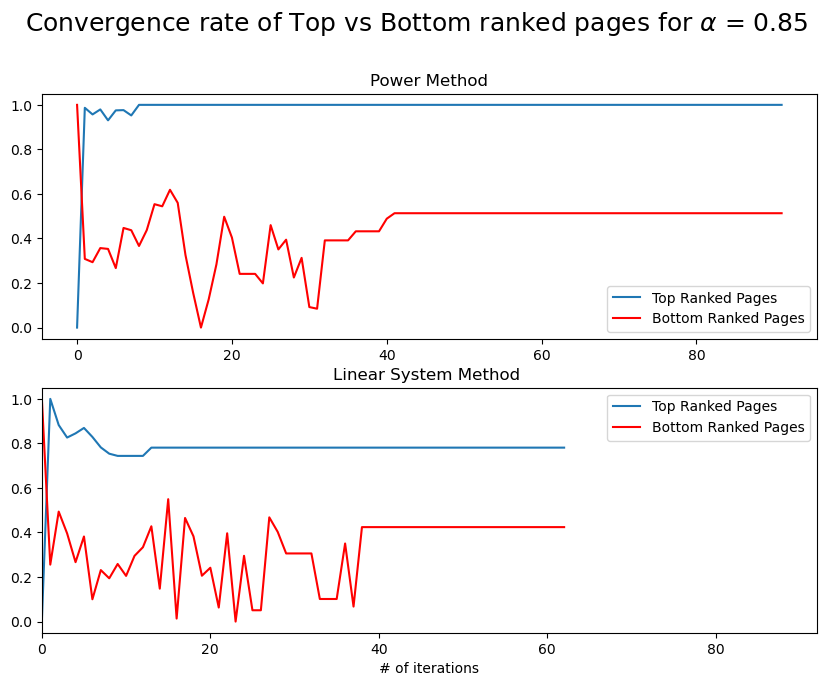

In [32]:
scaler = MinMaxScaler()

fig, ax = plt.subplots(2, 1, figsize=(10,7))

# power method
top_1 = scaler.fit_transform(top_pm.mean(axis=1).reshape(-1,1))
bottom_1 = scaler.fit_transform(bottom_pm.mean(axis=1).reshape(-1,1))
ax[0].plot(top_1, c='C0', label='Top Ranked Pages')
ax[0].plot(bottom_1, c='r', label='Bottom Ranked Pages')
ax[0].set_title('Power Method')
ax[0].legend()

# linear system method
top_2 = scaler.fit_transform(top_ls.mean(axis=1).reshape(-1,1))
bottom_2 = scaler.fit_transform(bottom_ls.mean(axis=1).reshape(-1,1))
ax[1].plot(top_2, c='C0', label='Top Ranked Pages')
ax[1].plot(bottom_2, c='r', label='Bottom Ranked Pages')
ax[1].set_title('Linear System Method ')
ax[1].set_xlabel('# of iterations')
ax[1].set_xlim(0, top_1.shape[0])
ax[1].legend()

fig.suptitle("Convergence rate of Top vs Bottom ranked pages for $\\alpha$ = 0.85", fontsize=18, y=1.0)
plt.show()

# Part 2

A typical way to raise the PageRank of a page is to use *link farms*, i.e., a collection of *fake* pages that point to yours in order to improve its PageRank. Our goal in this problem is to do a little analysis of the design of link farms, and how their structure affects the PageRank calculations. Consider the web graph. It contains n pages, labeled 1 through n: Of course, n is very large. As mentioned in, we use the notation $G = \alpha P + \dfrac{1- \alpha}{n} I$  for the transition matrix. Let $\pi_i$ denote the PageRank of page $i$ and $\pi = (\pi_1, \pi_2, \dots , \pi_n)$ denote the vector of PageRanks of all pages. 

Note:
For a page that has $k$ outgoing links, we put 1 = $k$ for the corresponding entries of
$P$: However, when a webpage has no outgoing links, we add a 1 as the corresponding
diagonal element of $P$ for making its row-sum one. Note that this makes $G$ a valid
transition probability matrix.

## a) Create new page $X$


You now create a new web page $X$ (thus adding a node to the web graph). $X$ has neither in-links, nor out-links. Let $\tilde{\pi} = (\tilde{\pi_{1}}, \tilde{\pi_{2}}, \cdots , \tilde{\pi_{n}})$ denote the vector of new PageRanks of the $n$ old web pages, and $x$ denote the new PageRank of page $X$: In other words, $(\tilde{\pi_{1}}, \tilde{\pi_{2}}, \cdots , \tilde{\pi_{n}}, x)$ is the PageRank vector of the new web graph. 

* Write $\tilde{\pi}$ and $x$ in terms of $\pi$: Comment on how the PageRanks of the older pages changed due to the addition of the new page (remember $n$ is a very large number). 

Hint: Use the stationary equations to calculate PageRank, not the iterative approach.

* Since $X$ will have no outgoing links it will have 1 in the corresponding diagonal element. We use the original dataframe, and add the $X$ page at the bottom.

In [33]:
def create_matrix(df):
    """
    Function that created the P matrix given a dataframe
    Input: pd.DataFrame
    Output: csr_matrix
    """
    df['Node'] = df['Node'].astype(int)
    df['Link'] = df['Link'].astype(int)

    # Define variables for the csr_matrix
    n = df.Node.max()

    # Python starts counting from zero we will correct that
    row = df.Node - 1
    column = df.Link - 1
    propabilities = df.Prob

    # define P matrix
    P = csr_matrix((propabilities, (row, column)), shape=(n, n))
    return P

In [34]:
# Copy data and add X
data_new = data.copy()
X_index = int(data_new.Node.max()+1)
data_new.loc[len(data_new.index)] = [X_index, X_index, 1.0]

# define new P
P_new = create_matrix(data_new)
P_new

<281904x281904 sparse matrix of type '<class 'numpy.float64'>'
	with 2312498 stored elements in Compressed Sparse Row format>

* We will use the power method with $\alpha = 0.85$ to fetch the rank.

In [35]:
x_2, iter_2, error_2, _, _ = power_method(P_new , 0.85, np.power(10.0, -8), False)

Method converged after 90 iterations for a=0.85


* The Rank of the new page is 47896, which is relatively low.

In [36]:
top = (np.argsort(x_2.flatten())+1)[::-1]
print(np.where(top == X_index)[0][0])

47896


* With the addition of $X$, some pages, in the top 50 PageRanks, changed. As we can see from the pages below, the pages in positions 14 and 15 have been reversed.

In [37]:
print("Old top 50 PageRanks:")
_ = sort_top_50(x_2)

print("\n\nNew top 50 PageRanks:")
print(top50_pm)

Old top 50 PageRanks:
[ 89073 226411 241454 262860 134832 234704 136821  68889 105607  69358
  67756 225872 186750 272442 251796  95163 119479 231363  55788 167295
 179645  38342 117152 198090  60210 235496 132695 181701 259455 247241
  62478 120708 161890  17781  77999 183004 221087 137632 176790  96745
 112742 145892 151428  81435  60440 208542     91 214128 258348 222873]


New top 50 PageRanks:
[ 89073 226411 241454 262860 134832 234704 136821  68889 105607  69358
  67756 225872 186750 251796 272442  95163 119479 231363  55788 167295
 179645  38342 117152 198090  60210 235496 132695 181701 247241 259455
 120708  62478 161890 176790 137632 221087 183004  77999  17781  96745
 112742 145892 151428  81435  60440 208542     91 214128 258348 222873]


* Let's count the number of differences.

In [38]:
old, new = (np.argsort(x_pm.flatten())+1)[::-1], (np.argsort(x_2[:-1,:].flatten())+1)[::-1]
print(f"Differences in PageRank with and without X: {np.where(new != old)[0].shape[0]}")

Differences in PageRank with and without X: 56852


* Write $\hat{\pi}$ and $x$ in terms of $\pi$.

We can find the indexes, in which pages have changed in $\hat{\pi}$ compared to $\hat{\pi}$ and locate the index of the old page in $\hat{\pi}$. We will make a small demonstration for the first 100 pages. 

With the addition of $X$ and due to the existance of $\alpha$ we can see that even the top PageRanks changed, even if $X$ has no outlinks. This is explained by the "random" factor that $\alpha$ adds to the problem.

In [39]:
for i, rank in enumerate(new):
    if i != np.where(old == rank)[0][0]:
        print(f"New index: {i:>2}, New Rank {rank:>6}, Old index {np.where(old == rank)[0][0]:>2}")
    if i == 100:
        break

New index: 13, New Rank 272442, Old index 14
New index: 14, New Rank 251796, Old index 13
New index: 30, New Rank  62478, Old index 31
New index: 31, New Rank 120708, Old index 30
New index: 33, New Rank  17781, Old index 38
New index: 34, New Rank  77999, Old index 37
New index: 35, New Rank 176790, Old index 33
New index: 36, New Rank 221087, Old index 35
New index: 37, New Rank 183004, Old index 36
New index: 38, New Rank 137632, Old index 34


## b) Create another page $Y$


Unsatisfied with the PageRank of your page $X$; you create another page $Y$ (with no in-links) that links to $X$: 

* What are the PageRanks of all the $n + 2$ pages now? 
* Does the PageRank of $X$ improve?

We follow the same steps as before to add page $Y$. 

In [40]:
Y_index = int(data_new.Node.max()+1)
data_new.loc[len(data_new.index)] = [Y_index, X_index, 1.0]

# define new P
P_new = create_matrix(data_new)
P_new

<281905x281905 sparse matrix of type '<class 'numpy.float64'>'
	with 2312499 stored elements in Compressed Sparse Row format>

In [41]:
x_2, iter_2, error_2, _, _ = power_method(P_new , 0.85, np.power(10.0, -8), False)
top = (np.argsort(x_2.flatten())+1)[::-1]

Method converged after 90 iterations for a=0.85


* As we can see with only 1 page ($Y$) pointing at $X$ the Rank of $X$ greatly improved. On The other hand, the Rank of $Y$ is lower than the previous rank of $X$. 

Intuatively, we might assume that pages with outlinks have lower rank that pages without links.

In [42]:
print(f"Pagerank of X: {np.where(top == X_index)[0][0]:>6}.") 
print(f"Pagerank of Y: {np.where(top == Y_index)[0][0]:>6}.")

Pagerank of X:  16180.
Pagerank of Y: 262924.


## c) Create another third page $Z$

Still unsatisfied, you create a third page $Z$: 

* How should you set up the links on your three pages so as to maximize the PageRank of $X$?

As we saw, having $X$ as an outlink of $Y$ increased its PageRank. We can create a new page $Z$ which will contain $X$ an outlink. That said, in order to maximize the PageRank of $X$ we do not want $Y$ and $Z$ to point at each other, since this would lower the probablility from $Y$ and $Z$ torwards $X$ and, in consequence, lower $X$'s PageRank.

After experimenting and trying the above, we create new $\bm{P}$ table and get the Ranks of our $n +3$ new pages. $X$'s PageRank has, once again, improved.

In [43]:
def run_pagerank(df, X_index, Y_index, Z_index):
    """
    Function that runs the PowerMethod and prints pagerank of given nodes
    Input: pd.DataFrame, index, index, index
    Output: None
    """
    
    # define new P
    P_new = create_matrix(data_new)

    x_2, iter_2, error_2, _, _ = power_method(P_new , 0.85, np.power(10.0, -8), False)
    top = (np.argsort(x_2.flatten())+1)[::-1]

    print(f"\nPagerank of X: {np.where(top == X_index)[0][0]:>6}.") 
    print(f"Pagerank of Y: {np.where(top == Y_index)[0][0]:>6}.")
    print(f"Pagerank of Z: {np.where(top == Z_index)[0][0]:>6}.")

In [44]:
# Copy data and add X
data_new = data.copy()
X_index = int(data_new.Node.max()+1)
Y_index = int(data_new.Node.max()+2)
Z_index = int(data_new.Node.max()+3)

data_new.loc[len(data_new.index)] = [X_index, X_index, 1]
data_new.loc[len(data_new.index)] = [Y_index, X_index, 1]
data_new.loc[len(data_new.index)] = [Z_index, X_index, 1]

run_pagerank(data_new, X_index, Y_index, Z_index)

Method converged after 90 iterations for a=0.85

Pagerank of X:  11114.
Pagerank of Y: 279491.
Pagerank of Z: 262924.


## d) Add links from $X$ to popular pages

You have one last idea, you add links from your page $X$ to older, popular pages (e.g.: you add a list of *Useful links* on your page). 

* Does this improve the PageRank of $X$? 
* Does the answer change if you add links from $Y$ or $Z$ to older, popular pages?

We will add the top 10 ranked pages as outlinks from $X$. As we can see the PageRank in now much lower. This is expected, since a page containing multiple links to popular pages is penalized.

In [45]:
# delete existing X node
data_new.drop(data_new.loc[data_new.Node == X_index].index, inplace=True)
data_new.reset_index(inplace=True, drop=True)

# Add 10 top pages for X
for i in top[:10]:
    data_new.loc[len(data_new.index)] = [X_index, i, 1/10]

run_pagerank(data_new, X_index, Y_index, Z_index)

Method converged after 90 iterations for a=0.85

Pagerank of X: 109089.
Pagerank of Y: 279491.
Pagerank of Z: 262924.


* By adding the top 10 pages to $Y$ and $Z$, the score of $X$ is lower, compared to when $Y$ and $Z$ only pointed to $X$.

In [46]:
# delete existing X, Y, Z node
data_new.drop(data_new.loc[(data_new.Node == X_index) | (data_new.Node == Y_index) | (data_new.Node == Z_index)].index, inplace=True)
data_new.reset_index(inplace=True, drop=True)

# Add X link
data_new.loc[len(data_new.index)] = [X_index, X_index, 1]

# Add X and top 10 pages to Y and Z
data_new.loc[len(data_new.index)] = [Y_index, X_index, 1/11]
data_new.loc[len(data_new.index)] = [Z_index, X_index, 1/11]

# Add 10 top pages for X
for i in top[:10]:
    data_new.loc[len(data_new.index)] = [Y_index, i, 1/11]
    data_new.loc[len(data_new.index)] = [Z_index, i, 1/11]

run_pagerank(data_new, X_index, Y_index, Z_index)

Method converged after 90 iterations for a=0.85

Pagerank of X:  27084.
Pagerank of Y: 279491.
Pagerank of Z: 262924.


## e) Raise the PageRank of $X$

Describe what steps you might take to raise the PageRank of $X$ further. You do not need to prove anything here, just summarize your thoughts based on the previous parts. For extra credit though, you can prove what the structure for a link farm with $m$ nodes should be to optimize the PageRank of $X$.

As described in the video [PageRank Explained](https://www.youtube.com/watch?v=MG0fIXfrT9A), a page's rank will greatly increase if a highly ranked page is pointing at it as shown in the figure below.

<img src="pagerank_explained.png" width="600" height="400">

Thus, we would have to add $X$ as an outlink to some important pages. Alternatively, $X$ should be an outlink to many pages, which, as we confirmed with $Y$ and $Z$, increased the PageRank. The second method (Link farming) was largely used in the past, in order to increase the PageRank, but since 2011 Google used the Panda algorithm (and many other since) to deal with link farming exploitation.  

We will test the first hypothesis, by adding $X$ as an outlink to the top ranked page. 

In [47]:
# Add X to top page
data_new.loc[len(data_new.index)] = [top[0], X_index, 1]
count_top = data_new.loc[(data_new.Node == top[0])].shape[0]

# readjust probs
df.value1 = data_new.loc[(data_new.Node == top[0]), 'Prob'] = 1/count_top

* As we can see, the fact that the top ranked page points to $X$ has greatly increased the rank of $X$. 

In [48]:
run_pagerank(data_new, X_index, Y_index, Z_index)

Method converged after 90 iterations for a=0.85

Pagerank of X:    129.
Pagerank of Y: 279491.
Pagerank of Z: 262924.
